#Unsupervised Text Classification of Amazon Reviews
This is the final project for DTSA 5799 (Unsupervised Text Classification For Marketing Analytics)

Reviews of Nike products with less than 4 stars are extracted from the Amazon review dataset and split into topics using k-means clustering in an effort to gain insight on what may influence a customer to leave a negative review.

You can also view the project on my GitHub repository here:
https://github.com/arwhit/reviews-topic-modeling

In [1]:
#Install and Import Required Packages
!pip install textblob
!pip install -U scikit-learn
import gzip
import json
import requests
import numpy as np
from textblob import TextBlob
import spacy
import re
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

## Data Extraction and Exploration
**Note:** This section describes the process of extracting Nike reviews with less than 4 stars for topic modeling following much of the methodology established in the course labs.

While you can follow along using the reference files provided in class and saving them to your Google Drive, the default behavior utilizes pre-extracted data hosted in a public Git repository. This approach reduces runtime and ensures usability even if the original reference files become unavailable or their URLs change.

In [3]:
#Set boolean value to determine starting point
full_extract=False
#Case for full extraction with matching google drive file path (following tutorial from lab coursework)
if full_extract==True:
  #mount drive
  from google.colab import drive
  drive.mount('/content/drive')
  #extract asins
  asins = []
  with gzip.open("/content/drive/MyDrive/Masters_Degree/Text_Marketing_Analytics/HW_Files/meta_Clothing_Shoes_and_Jewelry.gz") as products:
    for product in products:
        data = json.loads(product)
        categories = []
        for category_list in data.get("categories", []):
            _catlist = []
            for item in category_list:
                _catlist.append(item.lower())
            categories += _catlist
        if "nike" in categories:
            asins.append(data["asin"])
  #extract reviews with less than 4 stars
  bad_reviews = {}
  with gzip.open("/content/drive/MyDrive/Masters_Degree/Text_Marketing_Analytics/HW_Files/reviews_Clothing_Shoes_and_Jewelry.gz") as reviews:
    for i, review in enumerate(reviews):
        review = json.loads(review)
        if review["overall"] < 4 and review["asin"] in asins:
          _id = "%s.%s" % (review["asin"], review["reviewerID"])
          if review['asin'] in asins:
            bad_reviews[_id]=review
  print(len(bad_reviews), ' bad reviews extracted for further analysis')
  #write to file
  with open("/content/drive/MyDrive/Masters_Degree/Text_Marketing_Analytics/HW_Files/extracted_bad_reviews.jsonl", "w") as bad_reviews_file:
    for k, v in bad_reviews.items():
        review = json.dumps(v)
        bad_reviews_file.write(f"{review}\n")

#Case for referencing extracted reviews from git repository
else:
  extracted_bad_reviews=[]
  #specify url of jsonl file with the bad reviews
  url="https://raw.githubusercontent.com/arwhit/reviews-topic-modeling/main/extracted_bad_reviews.jsonl"
  response = requests.get(url)
  #Iterate through each line:
  for line in response.text.splitlines():
    review = json.loads(line)
    review_text=review["reviewText"]
    extracted_bad_reviews.append(review_text)

  print(len(extracted_bad_reviews), 'bad reviews have been extracted. Here is an example: \n')
  print(extracted_bad_reviews[0])


3903 bad reviews have been extracted. Here is an example: 

the colour i received is not blue as shown but yellow.Couldnt change it because it was a birthday present for my daughter and havent got time.She really didn,t like it


## Preprocessing
A total of 3,903 negative reviews were extracted. Manually labeling such a large volume of data would be time-consuming, highlighting the potential of unsupervised classification as an initial approach to uncover categories within the reviews.

To optimize model performance and reduce the document-term matrix (DTM) size, we employ the following pre-processing steps:

* **Lowercase:** This will help ensure words from different reviews that have different cases will be identified as the same
* **Spellcheck:** This data set has many spelling error. For example "didn,t" instead of "didn't" in the first review. We will use Textblobs built in corrector to address this.
* **Lemmatization:** This process converts words to their base form (e.g., "running" becomes "run"). Lemmatization helps capture the underlying meaning of words and improves model generalizability.
* **Stopword removal:** We eliminate common words with minimal semantic meaning (e.g., "the", "a", "and"). Removing stopwords reduces noise and allows the model to focus on content-bearing words.
* **Special character and punctuation removal:** Non-alphanumeric characters and punctuation are removed from the text (e.g., "@", "$", "?"). This step ensures the model processes meaningful textual content.

In [4]:
#Create Empty List for Cleaned Reviews
preprocessed_bad_reviews=[]

#Specify lemmatizer
spacy.require_gpu()
lemmatizer = spacy.load('en_core_web_sm')

#Iterate through list and preprocess the reviews
for review in extracted_bad_reviews:
  #lowercase
  review = review.lower()
  #spellcheck
  blob = TextBlob(review)
  corrected_review = blob.correct()
  filtered_text = str(corrected_review)
  #lemmatize
  doc = lemmatizer(filtered_text)
  #lemmatized_text = " ".join([token.lemma_ for token in doc])
  #Remove Stopwords
  filtered_words = [token.text for token in doc if not token.is_stop]
  filtered_text = " ".join(filtered_words)
  #remove special characters and punctuation
  punc_removed_text = re.sub(r"[^\w\s]", ' ', filtered_text)
  preprocessed_bad_reviews.append(punc_removed_text)

print('All reviews have been preprocessed. Here is an example: \n')
print(preprocessed_bad_reviews[0])


All reviews have been preprocessed. Here is an example: 

colour received blue shown yellow couldn change birthday present daughter haven got time she didn   t like


We now proceed to create the document-term matrix (DTM) that will serve as input for the topic models. Following common practice in unsupervised text classification, we employ Term Frequency-Inverse Document Frequency (TF-IDF) to weight terms within the DTM.

To further reduce the matrix size and focus on informative terms, we adopt the following filtering strategies:

* **Exclusion of common words:** We disregard words appearing in more than 50% of the reviews, as these are likely to be stop words with minimal discriminatory power.
* **Rare word removal:** We exclude words that occur in less than 5 reviews, as their infrequency limits their contribution to topic identification.

In [82]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=5, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(preprocessed_bad_reviews)
print(f"n_samples: {tfidf.shape[0]}, n_features: {tfidf.shape[1]}\n")
print(f"Nonzero terms: {100*tfidf.nnz / np.prod(tfidf.shape):.3f}%")

n_samples: 3903, n_features: 2077

Nonzero terms: 0.872%


That's still a lot of features and nonzero terms. We will further reduce the number of features using Single Value Decomposition (SVD) to make the matrix less sparse in an attempt to avoid the "curse of dimmensionality". This should also help reduce the runtime.

In [83]:
#Reduce to 100 Components
reduced = make_pipeline(TruncatedSVD(n_components=100, random_state=5), Normalizer(copy=False))
SVD_reduced = reduced.fit_transform(tfidf)
explained_variance = reduced[0].explained_variance_ratio_.sum()
print(f"n_components:{100}, explained variance: {100*explained_variance:.1f}%")

n_components:100, explained variance: 32.1%


We see over 30% of the feature space can be represented by only 100 components.

## Data Modeling
Now that the data has been vectorized and reduced we can start topic modeling. We will attempt to use k-means clustering as an usupervised learning approach. Since we do not have labels for the data, we need to establish some other metrics to determine the ideal model to use. We will attempt to use both the within clustter sum of squares and silloute score to select the optimal numbers of clusters

In [84]:
#Fit models from 2 to 10 cluster size
n_clusters=list(range(2,11))
WCSS=[]
Silhouette=[]
for clusters in n_clusters:
  kmeans = KMeans(
    n_clusters=clusters,
    max_iter=100,
    n_init=1,
    random_state=5)
  kmeans.fit(SVD_reduced)
  #Record the Within-Cluster Sum of Squares
  WCSS.append(kmeans.inertia_)
  #Record the Silhouette Score
  Silhouette.append(silhouette_score(SVD_reduced, kmeans.labels_))

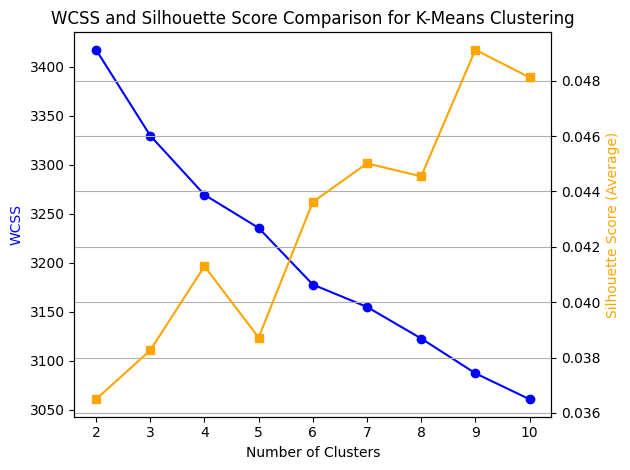

In [85]:
# Define distinct colors and markers for WCSS and Silhouette
wcss_color = 'blue'
wcss_marker = 'o'
silhouette_color = 'orange'
silhouette_marker = 's'

# Create the figure and primary axis
fig, ax1 = plt.subplots()

# WCSS plot on primary axis
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('WCSS', color=wcss_color)
ax1.plot(n_clusters, WCSS, marker=wcss_marker, linestyle='-', color=wcss_color, label='WCSS')

# Silhouette Score plot on secondary axis (using twinx)
ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score (Average)', color=silhouette_color)
ax2.plot(n_clusters, Silhouette, marker=silhouette_marker, linestyle='-', color=silhouette_color, label='Silhouette Score')

# Customize plot appearance for readability
plt.title('WCSS and Silhouette Score Comparison for K-Means Clustering')
plt.xticks(n_clusters)  # Set x-axis ticks for clarity
plt.grid(True)
plt.tight_layout()
plt.show()

Looking at the plot of WCSS and Silhouette score it appears 7 clusters is optimal for the k-means model. Let's extract the top words and see if they are meaningful. We will define a helpful word plotting funciton adapted from the sklearn documentaiton (see sources section)

In [93]:
#Use optimal number of clusters
kmeans = KMeans(
    n_clusters=7,
    max_iter=100,
    n_init=1,
    random_state=5)
kmeans.fit(SVD_reduced)

#Convert the Model back to words and explore the top words in each cluster
original_space_centroids = reduced[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()

#Print Top Words In Each Cluster
for i in range(7):
    print(f"Cluster {i+1}: ", end="")
    for ind in order_centroids[i, :15]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 1: product good quality like price expected buy material shoes time shoe poor better received disappointed 
Cluster 2: shoe like shoes running foot good comfortable wear support feet fit look looking sole buy 
Cluster 3: shoes like pair buy running bought shoe comfortable time good wear fit feet got run 
Cluster 4: color black white pink red like picture received shoes different wrong blue love shoe grey 
Cluster 5: size small ordered shoes fit 10 shoe wear like order tight larger bigger half 11 
Cluster 6: watch band like wrist time battery broke face months bought watches year display strap looks 
Cluster 7: like feet fit look socks foot comfortable wear pair return 34 small great narrow speakers 


## Model Evaluation and Summary
The model appears to have formed some ok topics, but there is always room for improvement. We will explore topics 1, 4,5, 6 and 7 in the Conclusions/Marketing Insights section, but will summarize the topics here:
1. Product quality does not match the price.
2. Shoes that are comfortable and a good fit (odd that these are under 3 stars)
3. Running Shoes reviews
4. The color does not match customers expectations.
5. The SHOE size does not match customers expectations.
6. Watches that have broken components
7. More fit related reviews but not as shoe specific.

## Conclusions and Marketing Insights
Based on the cluster analysis, the following key recommendations can be made to improve customer satisfaction and marketing strategies:

**Topic 1: Quality**
* Observation: Customers expect premium materials for products priced at a premium. Disappointment with material quality leads to returns.
* Action: Clearly communicate the quality of materials used in product descriptions. Highlight durable or high-quality materials in marketing materials and target messaging to emphasize value for the price point.

**Topic 4: Color**
* Observation:Inaccurate product color representation in pictures leads to returns.
* Action: Invest in high-quality product photography that accurately reflects color variations. Consider including color swatches or using 360° product views. Include color variations in product titles to avoid confusion.


**Topic 5 and 7: Fit**
* Observation: Online shoe returns are high due to sizing inconsistencies.
* Action: Develop a comprehensive size guide with clear instructions on measuring feet for proper fit. Offer customer reviews with insights on sizing (e.g., "runs large" or "narrow fit"). Consider a program for free return shipping on size exchanges.

**Topic 6: Watch Design**
* Observation:Watch returns are high due to breakage of watch face, wristband, or battery.
* Action: Focus on manufacturing with high-quality, durable materials for these key components. Promote the watch's durability and lifespan in marketing campaigns. Consider offering extended warranties to build trust and confidence.


It is also worth noting some customers leave positive written reviews with low star ratings. Encourage specific and detailed feedback in review prompts. Respond to all reviews, especially negative ones, and offer solutions or explanations where possible.

Unsupervised clustering can be a quick way to identify and address customer pain points, improve brand perception, and ultimately reduce return rates and increase customer satisfaction

## Sources
1. https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews
2. https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py
3. https://spacy.io/api
4. https://textblob.readthedocs.io/en/dev/